# Sentiment Analysis Model - TF-IDF

change current directory and import packages

In [1]:
%load_ext lab_black
import os
import numpy as np

In [2]:
if not os.path.exists("/sentiment_analysis"):
    os.chdir("..")

import packages

In [3]:
from sentiment_analysis.utils.train_test_split import TrainTestSplit
from sentiment_analysis.models.model import StreamlinedModel
from sentiment_analysis.features.tf_idf import TermFrequency_InvDocFrequency
from sentiment_analysis.data.review_processor import ReviewProcessor
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import matplotlib.pyplot as plt
import lightgbm as lgb
import shap
import pandas as pd

Perform train test split on the reviews data

In [4]:
X_train, y_train, X_test, y_test = TrainTestSplit().get_split_data()

### Logisitic Regression

In [5]:
logistic = StreamlinedModel(
    transformer_description="TF-IDF",
    transformer=TermFrequency_InvDocFrequency,
    model_description="logisitc regression model",
    model=LogisticRegression,
)

train the streamlined model

In [6]:
logistic.train(X_train, y_train)

In [7]:
print("Train accuracy:", logistic.score(X_train, y_train))
print("Test accuracy:", logistic.score(X_test, y_test))

Train accuracy: 0.9163888888888889
Test accuracy: 0.83875


get predictions

In [8]:
y_pred = logistic.predict(X_test)
y_prob_lg = logistic.predict_proba(X_test)

In [9]:
print("Test ROC:", roc_auc_score(y_test, y_prob_lg[:, 1]))

Test ROC: 0.8956875


### Naive Bayes

In [12]:
gaussian_naive_bayes = StreamlinedModel(
    transformer_description="TF-IDF",
    transformer=TermFrequency_InvDocFrequency,
    model_description="naive bayes model",
    model=GaussianNB,
)

In [13]:
gaussian_naive_bayes.train(X_train, y_train)

In [14]:
print("Train accuracy:", gaussian_naive_bayes.score(X_train, y_train))
print("Test accuracy:", gaussian_naive_bayes.score(X_test, y_test))

Train accuracy: 0.9361111111111111
Test accuracy: 0.62


In [15]:
y_pred = gaussian_naive_bayes.predict(X_test)
y_prob_gnb = gaussian_naive_bayes.predict_proba(X_test)

In [16]:
print("Test ROC:", roc_auc_score(y_test, y_prob_gnb[:, 1]))

Test ROC: 0.6187625


In [17]:
multinomial_naive_bayes = StreamlinedModel(
    transformer_description="TF-IDF",
    transformer=TermFrequency_InvDocFrequency,
    model_description="naive bayes model",
    model=MultinomialNB,
)

In [18]:
multinomial_naive_bayes.train(X_train, y_train)

In [19]:
print("Train accuracy:", multinomial_naive_bayes.score(X_train, y_train))
print("Test accuracy:", multinomial_naive_bayes.score(X_test, y_test))

Train accuracy: 0.9101388888888889
Test accuracy: 0.82125


In [20]:
y_pred = multinomial_naive_bayes.predict(X_test)
y_prob_mnb = multinomial_naive_bayes.predict_proba(X_test)

In [21]:
print("Test ROC:", roc_auc_score(y_test, y_prob_mnb[:, 1]))

Test ROC: 0.89741875


### LightGBM

Build TF-IDFs and lightGBM model and train using the training data

In [22]:
lightgbm = StreamlinedModel(
    transformer_description="TF-IDF",
    transformer=TermFrequency_InvDocFrequency,
    model_description="LightGBM model",
    model=lgb.LGBMClassifier,
    model_params={
        "application": "binary",
        "objective": "binary",
        "metric": "auc",
        "is_unbalance": "false",
        "boosting": "gbdt",
        "num_leaves": 31,
        "feature_fraction": 0.06,
        "bagging_fraction": 0.67,
        "bagging_freq": 1,
        "learning_rate": 0.05,
        "verbose_eval": 0,
        "n_estimators": 2000,
        "n_jobs": 6,
    },
)

train the streamlined model

In [23]:
lightgbm.train(X_train, y_train)

get scores

In [24]:
print("Train accuracy:", lightgbm.score(X_train, y_train))
print("Test accuracy:", lightgbm.score(X_test, y_test))

Train accuracy: 0.9993055555555556
Test accuracy: 0.80125


get predictions and predicted probabilities

In [25]:
y_pred = lightgbm.predict(X_test)
y_prob_lgbm = lightgbm.predict_proba(X_test)

In [26]:
print("Test ROC:", roc_auc_score(y_test, y_prob_lgbm[:, 1]))

Test ROC: 0.88838125


We were able to achieve some quite amazing results with LightGBM model. The next two steps we can have a look are

1. Check the most wrong positive and negative reviews
2. use SHAP to understand which word are more likely to lead to lightGBM 

**Most wrong positive/negative reviews**

get the raw review texts and rank by smallest distance of 0/1

In [27]:
wrong_positive_inds = np.where((y_test == 1) & (y_pred != y_test))[0]
wrong_negative_inds = np.where((y_test == 0) & (y_pred != y_test))[0]

In [28]:
most_wrong_positive_index = wrong_positive_inds[
    y_prob_lgbm[:, 1][wrong_positive_inds].argmax()
]
most_wrong_negative_index = wrong_negative_inds[
    y_prob_lgbm[:, 1][wrong_negative_inds].argmin()
]

In [29]:
print("Most wrong positive review: \n")

print(np.array(X_test)[most_wrong_positive_index])

Most wrong positive review: 

If you are just starting out on photography, I highly recommend this book. It begins immediately on the first chapter on picture making! For this reason alone, I would give it 5 stars. Here in the first chapter, the authors wasted no time to tell you what makes good pictures: the photographer, not the equipment. They then proceed to explain why the majority of our pictures (at least, the rest of us non-professionals) turn out unflattering despite our best efforts and high-tech cameras. If you read nothing else but the first chapter alone, I would bet that your photography will already begin to improve. Or if not, the first chapter will at least inspire you to try the suggestions and see the result yourself. In fact, even if all you have is a humble point and shoot film camera, the things they teach in the first chapter are still totally valid, as the principles of good photography remains the same whether you use film or digital.The next chapters give deta

In [30]:
print("Most wrong negative review: \n")

print(np.array(X_test)[most_wrong_negative_index])

Most wrong negative review: 

I stumbled across this book by accident at my library and decided what the heck, all those millions reading Gray's franchise can't be wrong.  Plus, I've seen Gray on Larry King once, and he seemed like a nice and reasonable enough guy.  This book, though, promising in its intro to be "sexy", touched more of my comical than my sensual nerves.  Now, I am not above accepting bedroom advice where it's warranted (for instance, it is thanks to Dr. Gray that I finally made sense of that night years ago when my husband slept on the couch after a huge fight caused by my criticizing a movie we'd just went to see).  But Gray's generalizations, dumbing down of most issues and sharing his own sex life with his wife Bonnie were mostly unhelpful, and I suspect that the passages I found funny were involuntarily so. Although I'm the first to admit that women love compliments, Gray's suggestions, as displayed in several top 10-lists of things to say (and, occasionally, what

As we can see, the most wrong positive/negative reviews would be pretty tough to get right even for human

**SHAP Model Explanation**

get shap explainer and training data

In [31]:
shap_explainer = shap.TreeExplainer(lightgbm.pipeline.steps[1][1])
training_data_transformed = lightgbm.pipeline.steps[0][1].transform(X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [33]:
words_index_map = lightgbm.pipeline.steps[0][1].word_to_index_map
words_index_map = {k: v for k, v in sorted(words_index_map.items(), key=lambda x: x[1])}
column_names = list(words_index_map.keys())
training_data_transformed = pd.DataFrame(
    training_data_transformed, columns=column_names
)

get shap values

In [34]:
shap_values = shap_explainer.shap_values(training_data_transformed)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


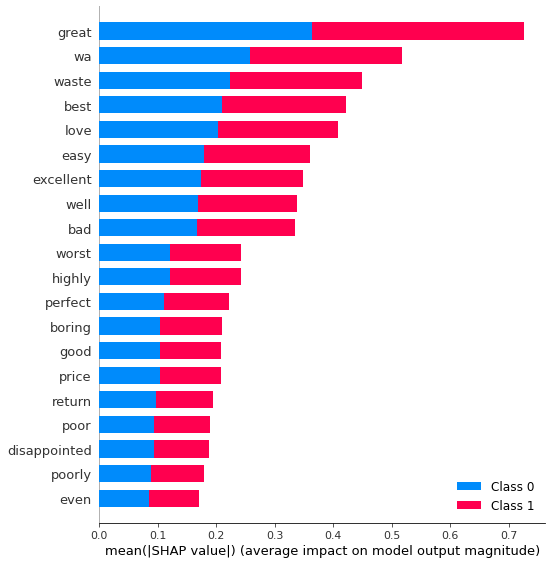

In [35]:
shap.summary_plot(shap_values, training_data_transformed)

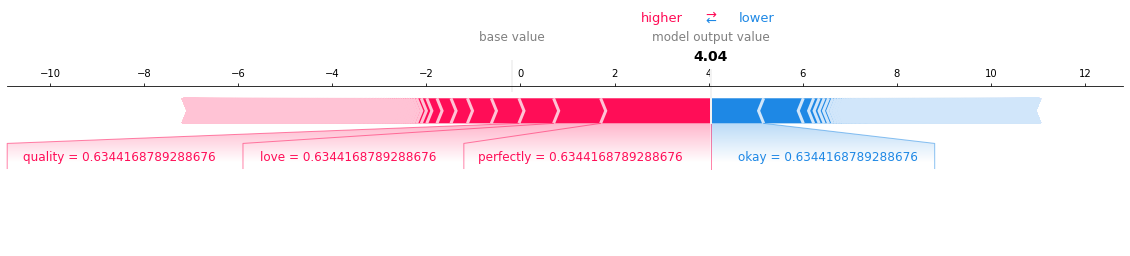

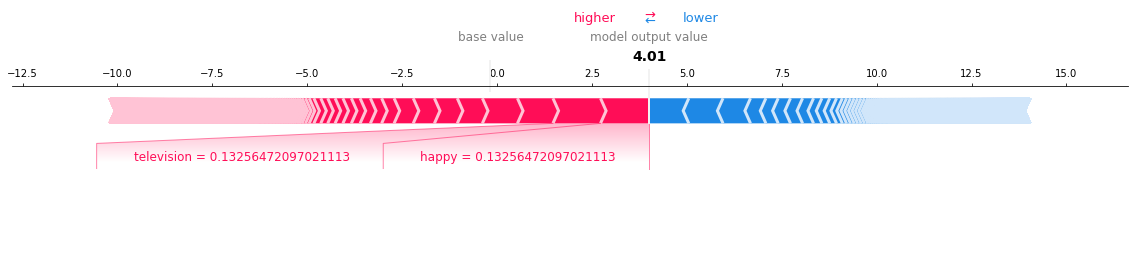

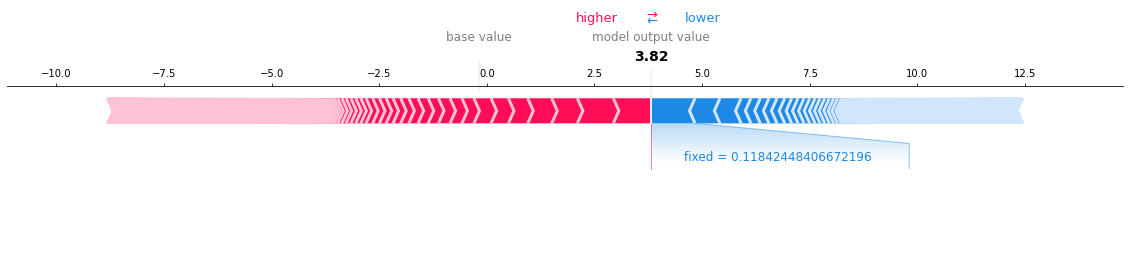

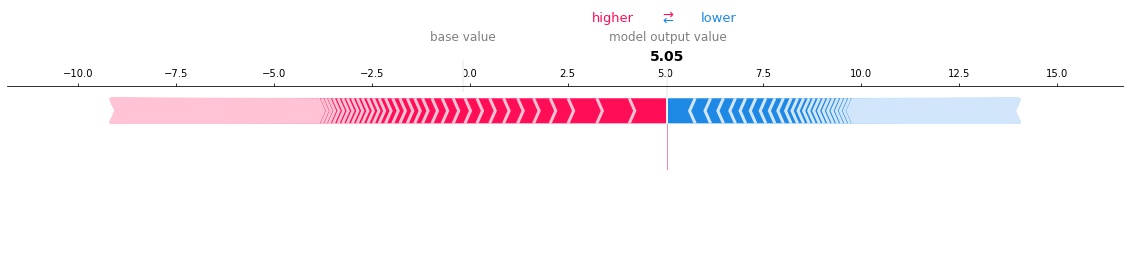

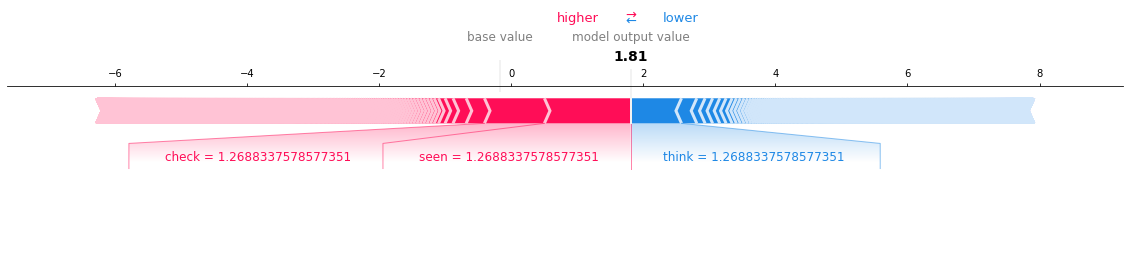

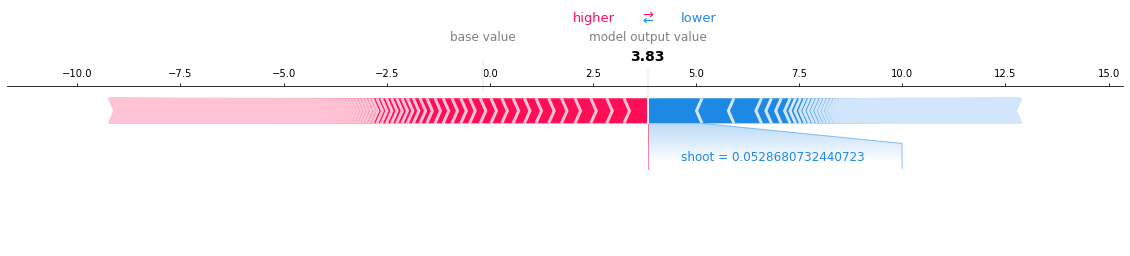

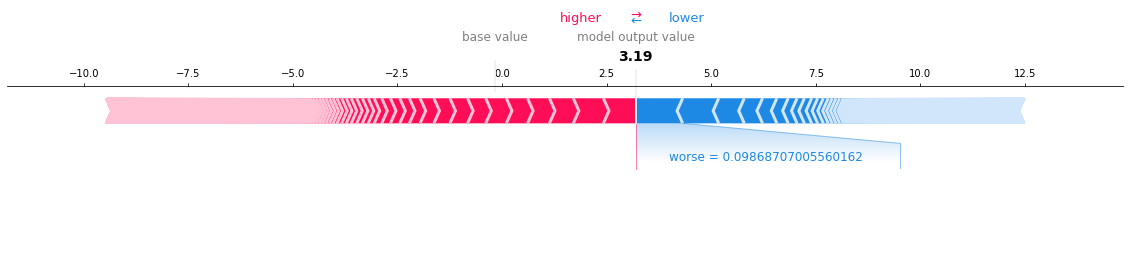

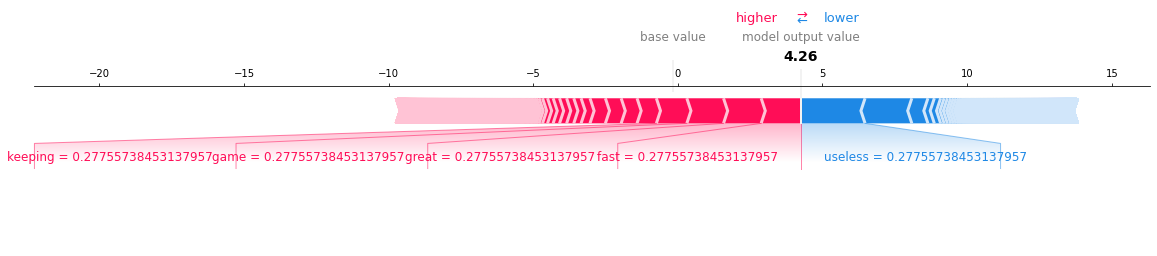

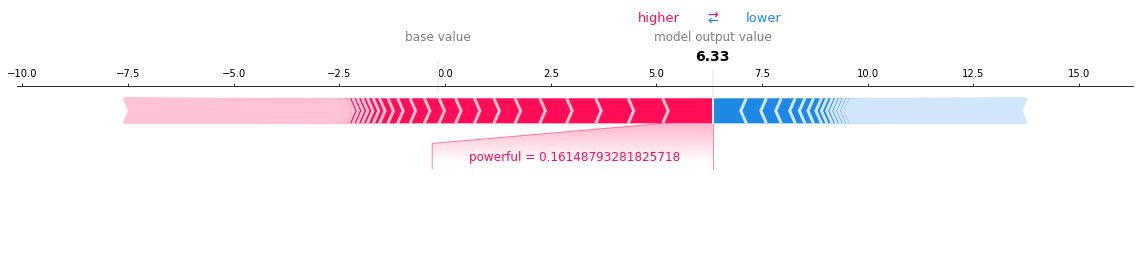

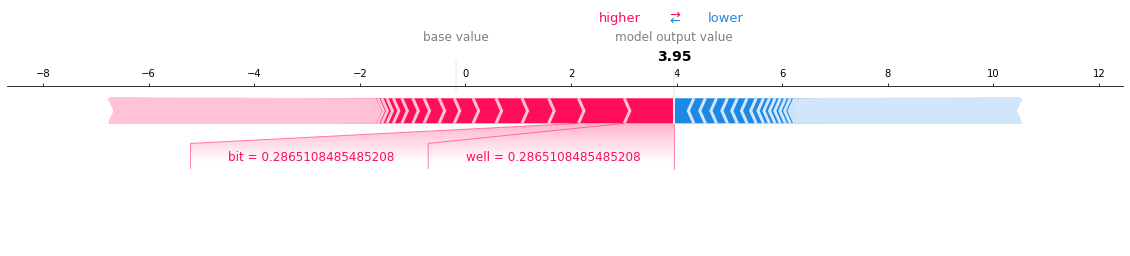

In [36]:
probs_low_to_high = np.argsort(y_prob_lgbm[:, 1])
for i in range(10):
    shap.force_plot(
        shap_explainer.expected_value[1],
        shap_values[1][probs_low_to_high[-(i + 1)], :],
        training_data_transformed.iloc[probs_low_to_high[-(i + 1)], :],
        matplotlib=True,
    )

summary

In [40]:
aucs = pd.DataFrame(
    {
        "model": [
            "logistic regression",
            "gaussian naive bayes",
            "multinomial naive bayes",
            "lightgbm",
        ],
        "auc": [
            roc_auc_score(y_test, y_prob_lg[:, 1]),
            roc_auc_score(y_test, y_prob_gnb[:, 1]),
            roc_auc_score(y_test, y_prob_mnb[:, 1]),
            roc_auc_score(y_test, y_prob_lgbm[:, 1]),
        ],
    }
)

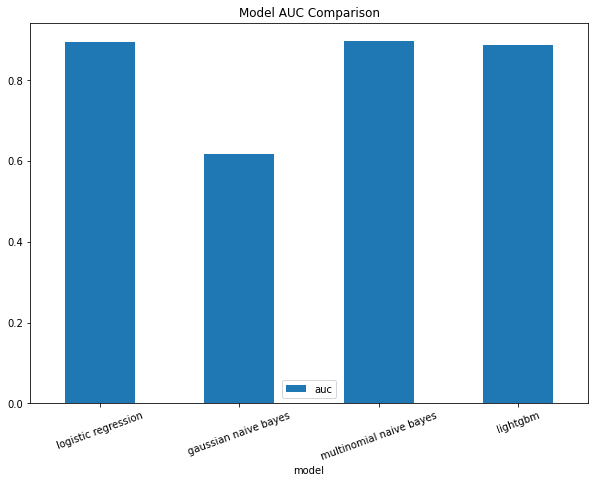

In [41]:
aucs.set_index("model").plot(
    kind="bar", figsize=(10, 7), title="Model AUC Comparison", rot=20
)